In [2]:
from numba import cuda
import numpy as np
from PIL import Image
import numpy as np
import time
import math

img_path = '../images/8k.jpg'

img = np.array(Image.open(img_path))
dog_img = np.array(Image.open('../images/dog.jpg').convert('RGB').resize((img.shape[1], img.shape[0])), dtype=np.float32)

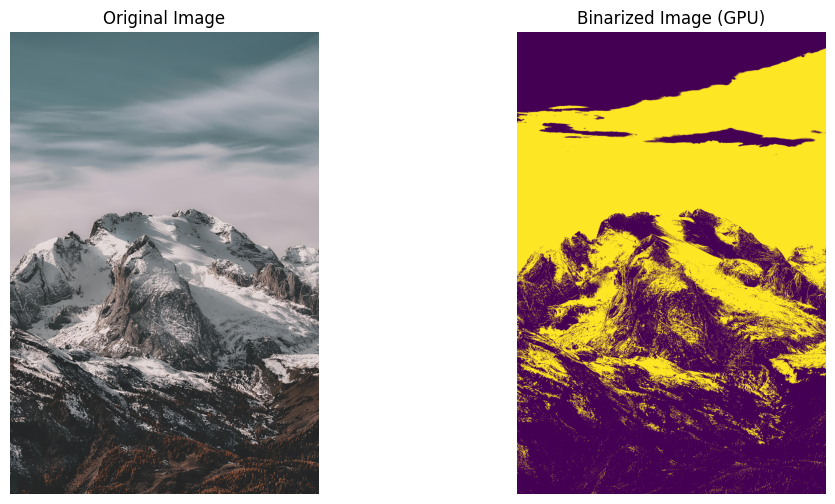

In [3]:
# implement grayscale binarization kernel (Map operation)
@cuda.jit
def binarize_kernel(img, out):
    x, y = cuda.grid(2)
    if x >= img.shape[0] or y >= img.shape[1]:
        return
    r, g, b = img[x, y]
    gray = (r + g + b) // 3
    out[x, y] = 1 if gray > 128 else 0


threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + (threadsperblock[0] - 1)) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + (threadsperblock[1] - 1)) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)
start = time.time()
img_gpu = cuda.to_device(img)
dat_gpu = cuda.device_array((img.shape[0], img.shape[1]), dtype=np.uint8)
binarize_kernel[blockspergrid, threadsperblock](img_gpu, dat_gpu)
cuda.synchronize()
dat = dat_gpu.copy_to_host()
end = time.time() - start

import matplotlib.pyplot as plt
img_out = Image.fromarray(dat)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(dat)
ax[1].set_title('Binarized Image (GPU)')
ax[1].axis('off')
plt.show()

Time taken: 0.5583932399749756 seconds


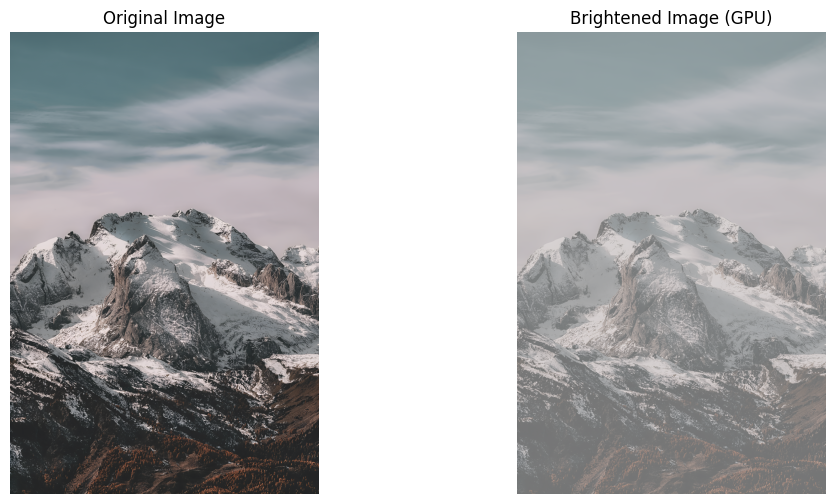

In [5]:
# increase image brightness
@cuda.jit
def brighten_kernel(img, out):
    x, y = cuda.grid(2)
    if x >= img.shape[0] or y >= img.shape[1]:
        return
    r, g, b = img[x, y]
    # plus 10 to each, if exceed 255, set to 255
    r = min(255, int(r * 0.5 + 100))
    g = min(255, int(g * 0.5 + 100))
    b = min(255, int(b * 0.5 + 100))
    out[x, y, 0] = r
    out[x, y, 1] = g
    out[x, y, 2] = b

threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + (threadsperblock[0] - 1)) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + (threadsperblock[1] - 1)) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)
start = time.time()
img_gpu = cuda.to_device(img)
dat_gpu = cuda.device_array((img.shape[0], img.shape[1], 3), dtype=np.uint8)
brighten_kernel[blockspergrid, threadsperblock](img_gpu, dat_gpu)
cuda.synchronize()
dat = dat_gpu.copy_to_host()
end = time.time() - start
print(f"Time taken: {end} seconds")


import matplotlib.pyplot as plt
img_out = Image.fromarray(dat)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(dat)
ax[1].set_title('Brightened Image (GPU)')
ax[1].axis('off')
plt.show()

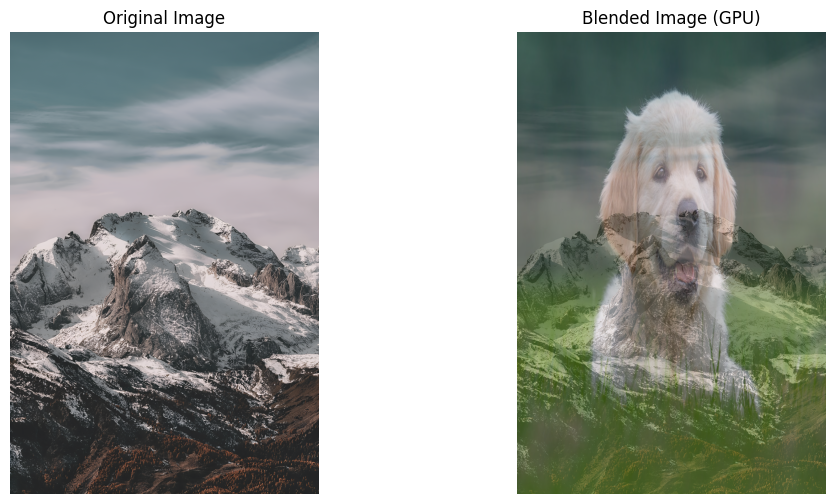

In [ ]:
c = 0.5


@cuda.jit
def blend_kernel(img1, img2, out):
    x, y = cuda.grid(2)
    if x >= img1.shape[0] or y >= img1.shape[1]:
        return
    r1, g1, b1 = img1[x, y]
    r2, g2, b2 = img2[x, y]
    r = min(255, int(r1 * c + r2 * (1 - c)))
    g = min(255, int(g1 * c + g2 * (1 - c)))
    b = min(255, int(b1 * c + b2 * (1 - c)))
    out[x, y, 0] = r
    out[x, y, 1] = g
    out[x, y, 2] = b
    

threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + (threadsperblock[0] - 1)) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + (threadsperblock[1] - 1)) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)
start = time.time()
img_gpu = cuda.to_device(img)
dog_img_gpu = cuda.to_device(dog_img)
dat_gpu = cuda.device_array((img.shape[0], img.shape[1], 3), dtype=np.uint8)
blend_kernel[blockspergrid, threadsperblock](img_gpu, dog_img_gpu, dat_gpu)
cuda.synchronize()
dat = dat_gpu.copy_to_host()
end = time.time() - start

import matplotlib.pyplot as plt
img_out = Image.fromarray(dat)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))   
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(dat)
ax[1].set_title('Blended Image (GPU)')
ax[1].axis('off')
plt.show()